#**Discovering Symbolic Models from Deep Learning with Inductive Biases**
## Implementazione del [modello originale proposto dagli autori](https://github.com/MilesCranmer/symbolic_deep_learning).

Contestabile Giorgio, De Mei Vincenzo, Macaluso Nicolò

[Link alla cartella GitHuB contenente codici e risultati del presente lavoro](https://github.com/gitNoYokai/symbolic_deep_learning_GNV)

Il progetto qui proposto vuole mostrare come sia possibile convertire una rete neurale in una semplice equazione analitica.
Gli autori hanno ritenuto opportuno suddividere la discussione in due notebook: 

1.   il presente, **GNN_Training**, dove vengono simulati sistemi di particelle interagenti tramite uno specifico potenziale (scelto dall'utente) ed ogni evento viene memorizzato sotto forma di un grafo dove le particelle vanno a costituire i nodi. Dagli edge vengono estrapolate le informazioni sull'interazione, dunque segue un allenamento della rete sui valori dell'accelerazione;   
2.   il notebook **Symbolic_Regression**, contenente la regressione simbolica dei risultati ottenuti dalla simulazione.




# 1. Preambolo e Simulazione

### Importazione delle librerie di base

In [1]:
# Basic pre-reqs:
import numpy as np
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
version_nums = torch.__version__.split('.')
# Torch Geometric seems to always build for *.*.0 of torch :
version_nums[-1] = '0' + version_nums[-1][1:]
os.environ['TORCH'] = '.'.join(version_nums)
 
!pip install --upgrade torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 45.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 40.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 34.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=5d4c5679701cb6c8081938a73f03b9e975463decee3003a792c7074b877e1b7a
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [4]:
!wget https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/models.py -O models.py
!wget https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/simulate.py -O simulate.py

--2022-11-08 09:38:53--  https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9647 (9.4K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   9.42K  --.-KB/s    in 0s      

2022-11-08 09:38:53 (63.5 MB/s) - ‘models.py’ saved [9647/9647]

--2022-11-08 09:38:53--  https://raw.githubusercontent.com/MilesCranmer/symbolic_deep_learning/master/simulate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9752 (9.5K) [text/p

### Importazione delle librerie per la modellizzazione della rete (**models**) e per le simulazioni fisiche (**simulate**)

In [5]:
import models
import simulate

In [6]:
torch.ones(1).cuda()

tensor([1.], device='cuda:0')

### Scelta della simulazione

In [7]:
# Number of simulations to run (it's fast, don't worry):
ns = 10000
# Potential (see below for options)
sim = 'spring'
# Number of nodes
n = 5
# Dimension
dim = 2
# Number of time steps
nt = 1000


#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
 {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'string', 'dt': [1e-2], 'nt': [1000], 'n': [30], 'dim': [2]},
 {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'superposition', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'damped', 'dt': [2e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'discontinuous', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
]


#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
print('Running on', title)

Running on spring_n=5_dim=2_nt=1000_dt=0.01


### Generazione dei dati della simulazione

In [8]:
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
# Update this to your own dataset, or regenerate:
base_str = './'
data_str = title
s.simulate(ns)

In [9]:
data = s.data
s.data.shape

(10000, 500, 5, 6)

### Visualizzazione della simulazione

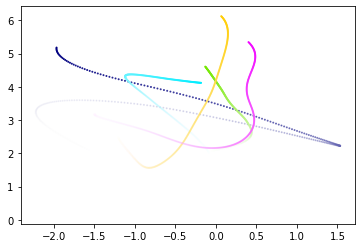

In [10]:
s.plot(0, animate=True, plot_size=False)

### Preparazione dei dati

In [11]:
accel_data = s.get_acceleration()

In [12]:
X = torch.from_numpy(np.concatenate([s.data[:, i] for i in range(0, s.data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, s.data.shape[1], 5)]))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# 2. Impostazione della Rete e Training

In [15]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [16]:
from models import OGN, varOGN, make_packer, make_unpacker, get_edge_index

### Scelta della Loss Function

Per applicare **Bottleneck**, è necessario porre la dimensionalità del messaggi pari a quella del sistema.

In [17]:
aggr = 'add'
hidden = 300

test = '_l1_'

#This test applies an explicit bottleneck:

msg_dim = 100
n_f = data.shape[3]

### Note degli Autori sulle Loss Function

L1 loss: we simply add the loss to the batch number. I.e., * 32 for batch size 32.

KL loss: model the messages as a distribution with the prior a Gaussian. The means add in the final Gaussian. 
Recall in the D_KL(p||q), the prior is q.  Then, for sigma_q = 1, mu_q = 0, we have ($p=1$):

$$D_{KL}(p||q) = \frac{\sigma_p^2 + \mu_p^2}{2} -\log({\sigma_p}) - \frac{1}{2}$$

### Data Loader personalizzato scelto dagli Autori

In [18]:
from torch_geometric.data import Data, DataLoader

In [19]:
from models import get_edge_index

In [20]:
edge_index = get_edge_index(n, sim)

### Inizializzazione del modello

In [21]:
if test == '_kl_':
    ogn = varOGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
else:
    ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()

messages_over_time = []
ogn = ogn.cuda()

In [22]:
_q = Data(
    x=X_train[0].cuda(),
    edge_index=edge_index.cuda(),
    y=y_train[0].cuda())
ogn(_q.x, _q.edge_index), ogn.just_derivative(_q).shape, _q.y.shape, ogn.loss(_q), 

(tensor([[-0.0298,  0.0464],
         [-0.0239,  0.0293],
         [-0.0225,  0.0378],
         [-0.0288,  0.0409],
         [-0.0322,  0.0388]], device='cuda:0', grad_fn=<AddmmBackward0>),
 torch.Size([5, 2]),
 torch.Size([5, 2]),
 tensor(29.7708, device='cuda:0', grad_fn=<SumBackward0>))

### Organizzazione dei dati

In [23]:
batch = int(64 * (4 / n)**2)
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

### Definizione delle Loss Function

In [25]:
def new_loss(self, g, augment=True, square=False):
    if square:
        return torch.sum((g.y - self.just_derivative(g, augment=augment))**2)
    else:
        base_loss = torch.sum(torch.abs(g.y - self.just_derivative(g, augment=augment)))
        if test in ['_l1_', '_kl_']:
            s1 = g.x[self.edge_index[0]]
            s2 = g.x[self.edge_index[1]]
            if test == '_l1_':
                m12 = self.message(s1, s2)
                regularization = 1e-2
                #Want one loss value per row of g.y:
                normalized_l05 = torch.sum(torch.abs(m12))
                return base_loss, regularization * batch * normalized_l05 / n**2 * n
            elif test == '_kl_':
                regularization = 1
                #Want one loss value per row of g.y:
                tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
                raw_msg = self.msg_fnc(tmp)
                mu = raw_msg[:, 0::2]
                logvar = raw_msg[:, 1::2]
                full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
                return base_loss, regularization * batch * full_kl / n**2 * n
        return base_loss

### Impostazione dei parametri per il training

Per vari potenziali, 150-200 epoche sono sufficienti per ottenere buoni risultati.

In [26]:
init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

total_epochs = 200

batch_per_epoch = int(1000*10 / (batch/32.0))

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

8000

In [27]:
epoch = 0

from tqdm import tqdm

### Organizzazione dei messaggi

In [28]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

# Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

### Funzione per la registrazione dell'output della rete

In [29]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)  # tmp has shape [E, 2 * in_channels]
        if test == '_kl_':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info

In [30]:
recorded_models = []

### Ciclo di Training

In [31]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cuda()
    total_loss = 0.0
    i = 0
    num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x.cuda()
            ginput.y = ginput.y.cuda()
            ginput.edge_index = ginput.edge_index.cuda()
            ginput.batch = ginput.batch.cuda()
            if test in ['_l1_', '_kl_']:
                loss, reg = new_loss(ogn, ginput, square=False)
                ((loss + reg)/int(ginput.batch[-1]+1)).backward()
            else:
                loss = ogn.loss(ginput, square=False)
                (loss/int(ginput.batch[-1]+1)).backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)

    cur_loss = total_loss/num_items
    print(cur_loss)
    cur_msgs = get_messages(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(ogn.state_dict())

  0%|          | 0/200 [00:00<?, ?it/s]

17.382543445396422


  1%|          | 2/200 [02:00<3:19:18, 60.40s/it]

11.42698990855217


  2%|▏         | 3/200 [03:00<3:17:42, 60.22s/it]

8.408820193243027


  2%|▏         | 4/200 [04:00<3:15:53, 59.97s/it]

6.834485334396362


  2%|▎         | 5/200 [05:00<3:14:24, 59.82s/it]

6.132752163410187


  3%|▎         | 6/200 [05:59<3:12:56, 59.67s/it]

5.658254514217377


  4%|▎         | 7/200 [06:59<3:11:47, 59.62s/it]

5.2898042664289475


  4%|▍         | 8/200 [07:58<3:10:36, 59.56s/it]

5.005158310413361


  4%|▍         | 9/200 [08:58<3:09:44, 59.60s/it]

4.756332468509674


  5%|▌         | 10/200 [09:58<3:09:03, 59.70s/it]

4.603821635723114


  6%|▌         | 11/200 [10:57<3:08:05, 59.71s/it]

4.350112423372269


  6%|▌         | 12/200 [11:57<3:07:26, 59.82s/it]

4.116643773388863


  6%|▋         | 13/200 [12:58<3:07:11, 60.06s/it]

3.8043705036640167


  7%|▋         | 14/200 [13:59<3:07:09, 60.37s/it]

3.4963879233002664


  8%|▊         | 15/200 [15:00<3:06:47, 60.58s/it]

3.158682920408249


  8%|▊         | 16/200 [16:01<3:05:46, 60.58s/it]

2.882046543943882


  8%|▊         | 17/200 [17:01<3:04:16, 60.42s/it]

2.5215082820534707


  9%|▉         | 18/200 [18:01<3:02:58, 60.32s/it]

2.3853383828639982


 10%|▉         | 19/200 [19:01<3:02:01, 60.34s/it]

2.1713003051400186


 10%|█         | 20/200 [20:01<3:00:42, 60.23s/it]

2.0518004914283754


 10%|█         | 21/200 [21:02<2:59:48, 60.27s/it]

1.9641332405030727


 11%|█         | 22/200 [22:02<2:58:57, 60.32s/it]

1.9314511237978935


 12%|█▏        | 23/200 [23:02<2:57:55, 60.32s/it]

1.8914305098056794


 12%|█▏        | 24/200 [24:03<2:56:50, 60.29s/it]

1.89745914375782


 12%|█▎        | 25/200 [25:03<2:56:21, 60.46s/it]

1.943512279611826


 13%|█▎        | 26/200 [26:04<2:55:18, 60.45s/it]

1.9349916280269623


 14%|█▎        | 27/200 [27:04<2:53:54, 60.31s/it]

1.8982098688840867


 14%|█▍        | 28/200 [28:04<2:52:57, 60.33s/it]

1.8955099140942098


 14%|█▍        | 29/200 [29:04<2:51:52, 60.31s/it]

1.9528107328355313


 15%|█▌        | 30/200 [30:05<2:50:45, 60.27s/it]

1.9418009419560431


 16%|█▌        | 31/200 [31:05<2:49:54, 60.32s/it]

1.9436895185947418


 16%|█▌        | 32/200 [32:05<2:48:32, 60.19s/it]

1.902584065592289


 16%|█▋        | 33/200 [33:04<2:46:47, 59.92s/it]

1.9445903285622597


 17%|█▋        | 34/200 [34:04<2:45:30, 59.82s/it]

1.9890970732688904


 18%|█▊        | 35/200 [35:04<2:44:20, 59.76s/it]

1.9585412116467953


 18%|█▊        | 36/200 [36:03<2:43:23, 59.78s/it]

1.962975021892786


 18%|█▊        | 37/200 [37:03<2:42:17, 59.74s/it]

1.96810859836936


 19%|█▉        | 38/200 [38:02<2:41:02, 59.64s/it]

1.942423816436529
1.97352174167037


 20%|█▉        | 39/200 [39:02<2:39:43, 59.52s/it]

1.9607649727582932


 20%|██        | 40/200 [40:01<2:38:35, 59.47s/it]

1.969437913954258


 20%|██        | 41/200 [41:01<2:37:41, 59.50s/it]

1.9281491270959377


 21%|██        | 42/200 [42:00<2:36:51, 59.57s/it]

1.976540162909031


 22%|██▏       | 43/200 [43:00<2:35:59, 59.62s/it]

1.9360926581025124


 22%|██▏       | 44/200 [43:59<2:34:48, 59.54s/it]

1.9350805766999721


 22%|██▎       | 45/200 [44:59<2:33:47, 59.53s/it]

1.9218583264112472


 23%|██▎       | 46/200 [45:59<2:32:53, 59.57s/it]

1.918560659122467


 24%|██▎       | 47/200 [46:58<2:32:03, 59.63s/it]

1.9486507444918155


 24%|██▍       | 48/200 [47:58<2:31:04, 59.63s/it]

1.890163138973713


 24%|██▍       | 49/200 [48:58<2:30:09, 59.67s/it]

1.9068307293951512


 25%|██▌       | 50/200 [49:57<2:29:10, 59.67s/it]

1.8639728594481946


 26%|██▌       | 51/200 [50:57<2:27:58, 59.59s/it]

1.8680487591087818


 26%|██▌       | 52/200 [51:56<2:26:59, 59.59s/it]

1.8266937764585018


 26%|██▋       | 53/200 [52:56<2:25:53, 59.55s/it]

1.8613504615187646


 27%|██▋       | 54/200 [53:55<2:24:53, 59.54s/it]

1.8320074831902982


 28%|██▊       | 55/200 [54:55<2:23:49, 59.52s/it]

1.8051144100427627


 28%|██▊       | 56/200 [55:55<2:23:00, 59.59s/it]

1.7512792746365071


 28%|██▊       | 57/200 [56:54<2:21:47, 59.49s/it]

1.770100381833315


 29%|██▉       | 58/200 [57:53<2:20:41, 59.45s/it]

1.7564769419908524


 30%|██▉       | 59/200 [58:52<2:19:31, 59.37s/it]

1.714795522493124


 30%|███       | 60/200 [59:51<2:18:18, 59.27s/it]

1.7269016817808152


 30%|███       | 61/200 [1:00:51<2:17:14, 59.24s/it]

1.7095981682896615


 31%|███       | 62/200 [1:01:50<2:16:15, 59.24s/it]

1.6778238060891628


 32%|███▏      | 63/200 [1:02:49<2:15:05, 59.16s/it]

1.6543470685422421


 32%|███▏      | 64/200 [1:03:48<2:14:00, 59.12s/it]

1.6456600431621076


 32%|███▎      | 65/200 [1:04:47<2:12:53, 59.06s/it]

1.6206061169087886


 33%|███▎      | 66/200 [1:05:46<2:11:56, 59.08s/it]

1.5991167729735374


 34%|███▎      | 67/200 [1:06:45<2:10:53, 59.05s/it]

1.5942351495206355


 34%|███▍      | 68/200 [1:07:44<2:10:04, 59.13s/it]

1.55748633005023


 34%|███▍      | 69/200 [1:08:43<2:08:59, 59.08s/it]

1.5632127268910407


 35%|███▌      | 70/200 [1:09:42<2:07:52, 59.02s/it]

1.5480977473318578


 36%|███▌      | 71/200 [1:10:41<2:07:07, 59.13s/it]

1.5114870657384396


 36%|███▌      | 72/200 [1:11:41<2:06:17, 59.20s/it]

1.5165642311513423


 36%|███▋      | 73/200 [1:12:40<2:05:05, 59.10s/it]

1.5060777587294578


 37%|███▋      | 74/200 [1:13:39<2:04:10, 59.13s/it]

1.4776450383484363


 38%|███▊      | 75/200 [1:14:38<2:03:12, 59.14s/it]

1.4807245777249336


 38%|███▊      | 76/200 [1:15:37<2:02:08, 59.10s/it]

1.4477348851084708


 39%|███▉      | 78/200 [1:17:35<2:00:20, 59.19s/it]

1.4315201818704606


 40%|███▉      | 79/200 [1:18:34<1:59:15, 59.13s/it]

1.418306091195345
1.412374109774828


 40%|████      | 80/200 [1:19:34<1:58:36, 59.31s/it]

1.3852435100376606


 41%|████      | 82/200 [1:21:33<1:56:40, 59.33s/it]

1.364630711555481
1.3557404126763344


 42%|████▏     | 83/200 [1:22:33<1:56:05, 59.54s/it]

1.3550554956376553


 42%|████▏     | 84/200 [1:23:33<1:55:10, 59.58s/it]

1.31683384039402


 43%|████▎     | 86/200 [1:25:33<1:53:55, 59.96s/it]

1.2965053336024284
1.2960063089728355


 44%|████▍     | 88/200 [1:27:34<1:52:22, 60.20s/it]

1.286289038783312
1.256303318476677


 44%|████▍     | 89/200 [1:28:34<1:51:11, 60.11s/it]

1.2301270496308803


 45%|████▌     | 90/200 [1:29:34<1:50:05, 60.05s/it]

1.2382355686724187


 46%|████▌     | 91/200 [1:30:34<1:49:01, 60.02s/it]

1.2067576364696027


 46%|████▌     | 92/200 [1:31:33<1:47:39, 59.81s/it]

1.191341752719879


 47%|████▋     | 94/200 [1:33:32<1:45:34, 59.76s/it]

1.197658585602045


 48%|████▊     | 95/200 [1:34:32<1:44:28, 59.70s/it]

1.172902718758583


 48%|████▊     | 96/200 [1:35:31<1:43:19, 59.61s/it]

1.1513237552821636
1.1390091018617152


 48%|████▊     | 97/200 [1:36:31<1:42:12, 59.54s/it]

1.1130198158204556


 49%|████▉     | 98/200 [1:37:30<1:41:11, 59.52s/it]

1.1276882667005061


 50%|█████     | 100/200 [1:39:29<1:39:08, 59.49s/it]

1.0938090778172016


 50%|█████     | 101/200 [1:40:29<1:38:13, 59.53s/it]

1.0897163972437383


 51%|█████     | 102/200 [1:41:28<1:37:10, 59.50s/it]

1.07783673787117


 52%|█████▏    | 103/200 [1:42:28<1:36:08, 59.47s/it]

1.0673161837637424
1.046625129634142


 52%|█████▎    | 105/200 [1:44:27<1:34:11, 59.49s/it]

1.032455353116989
1.0208793802857399


 54%|█████▎    | 107/200 [1:46:26<1:32:20, 59.58s/it]

1.0098973848879338


 54%|█████▍    | 108/200 [1:47:25<1:31:08, 59.44s/it]

1.0037261491835117


 55%|█████▍    | 109/200 [1:48:25<1:30:12, 59.48s/it]

0.9863938772916794


 55%|█████▌    | 110/200 [1:49:24<1:29:07, 59.42s/it]

0.984093036288023


 56%|█████▌    | 111/200 [1:50:23<1:28:06, 59.40s/it]

0.9512809564650059


 56%|█████▌    | 112/200 [1:51:23<1:27:11, 59.45s/it]

0.9631899718940258
0.9482586198627949


 57%|█████▋    | 114/200 [1:53:23<1:25:49, 59.88s/it]

0.9326224538832902


 57%|█████▊    | 115/200 [1:54:24<1:25:01, 60.02s/it]

0.9202305589407682


 58%|█████▊    | 116/200 [1:55:24<1:24:10, 60.13s/it]

0.904588514393568


 58%|█████▊    | 117/200 [1:56:25<1:23:17, 60.21s/it]

0.8871261943936348


 59%|█████▉    | 118/200 [1:57:25<1:22:12, 60.15s/it]

0.8687531459480524


 60%|█████▉    | 119/200 [1:58:25<1:21:13, 60.17s/it]

0.8657597826182842
0.8736018969774246


 60%|██████    | 120/200 [1:59:25<1:20:24, 60.31s/it]

0.8407312759160995


 61%|██████    | 122/200 [2:01:28<1:18:55, 60.71s/it]

0.8241079634726047


 62%|██████▏   | 123/200 [2:02:30<1:18:33, 61.21s/it]

0.8028609011173248


 62%|██████▏   | 124/200 [2:03:33<1:18:10, 61.71s/it]

0.8052530505120754


 62%|██████▎   | 125/200 [2:04:35<1:17:14, 61.80s/it]

0.7887164721131324


 63%|██████▎   | 126/200 [2:05:36<1:15:52, 61.51s/it]

0.7820511385232211


 64%|██████▎   | 127/200 [2:06:36<1:14:33, 61.28s/it]

0.7672082691133022
0.7320072335630655


 64%|██████▍   | 129/200 [2:08:37<1:11:49, 60.70s/it]

0.7425384442090989


 65%|██████▌   | 130/200 [2:09:37<1:10:35, 60.50s/it]

0.7275132640480996


 66%|██████▌   | 131/200 [2:10:37<1:09:19, 60.29s/it]

0.7105431289672851


 66%|██████▌   | 132/200 [2:11:36<1:08:08, 60.13s/it]

0.7056665947079659


 66%|██████▋   | 133/200 [2:12:36<1:07:00, 60.01s/it]

0.6925350664913654


 67%|██████▋   | 134/200 [2:13:36<1:05:59, 59.99s/it]

0.6801943583607674
0.6691031264156103


 68%|██████▊   | 136/200 [2:15:36<1:03:54, 59.91s/it]

0.6668910730540752


 68%|██████▊   | 137/200 [2:16:35<1:02:51, 59.86s/it]

0.6543645788550377


 69%|██████▉   | 138/200 [2:17:35<1:01:51, 59.87s/it]

0.6333146880477667


 70%|██████▉   | 139/200 [2:18:35<1:00:47, 59.80s/it]

0.6261446174144745
0.6242376199096441


 70%|███████   | 141/200 [2:20:35<58:48, 59.80s/it]

0.6066106955885887


 71%|███████   | 142/200 [2:21:34<57:44, 59.74s/it]

0.5988699718832969


 72%|███████▏  | 143/200 [2:22:34<56:42, 59.69s/it]

0.5915936004728078


 72%|███████▏  | 144/200 [2:23:33<55:43, 59.71s/it]

0.5785110068976879


 72%|███████▎  | 145/200 [2:24:33<54:39, 59.62s/it]

0.5701628647059203


 73%|███████▎  | 146/200 [2:25:32<53:33, 59.51s/it]

0.5527103896737099


 74%|███████▎  | 147/200 [2:26:32<52:35, 59.53s/it]

0.5467812918931246


 74%|███████▍  | 148/200 [2:27:31<51:37, 59.57s/it]

0.5375011815428734


 74%|███████▍  | 149/200 [2:28:31<50:37, 59.56s/it]

0.5301752309530974


 75%|███████▌  | 150/200 [2:29:30<49:35, 59.52s/it]

0.5153859609514475


 76%|███████▌  | 151/200 [2:30:30<48:35, 59.50s/it]

0.5102760206788778


 76%|███████▌  | 152/200 [2:31:29<47:34, 59.47s/it]

0.5046200197696685


 76%|███████▋  | 153/200 [2:32:29<46:34, 59.45s/it]

0.4963969073653221


 77%|███████▋  | 154/200 [2:33:28<45:31, 59.38s/it]

0.485708356654644


 78%|███████▊  | 155/200 [2:34:27<44:33, 59.41s/it]

0.48068426946997644


 78%|███████▊  | 156/200 [2:35:27<43:35, 59.44s/it]

0.4723184518933296
0.4702586830437183


 79%|███████▉  | 158/200 [2:37:26<41:37, 59.46s/it]

0.4597598694175482


 80%|███████▉  | 159/200 [2:38:25<40:36, 59.43s/it]

0.4522748388558626


 80%|████████  | 160/200 [2:39:24<39:36, 59.41s/it]

0.44435657738149165


 80%|████████  | 161/200 [2:40:24<38:38, 59.45s/it]

0.4363292156130075


 81%|████████  | 162/200 [2:41:24<37:42, 59.53s/it]

0.4302338428914547


 82%|████████▏ | 163/200 [2:42:23<36:44, 59.57s/it]

0.42510332089066505


 82%|████████▏ | 164/200 [2:43:23<35:43, 59.54s/it]

0.41895608560442926


 82%|████████▎ | 165/200 [2:44:22<34:43, 59.52s/it]

0.4157986446529627


 83%|████████▎ | 166/200 [2:45:22<33:43, 59.53s/it]

0.4070514251768589


 84%|████████▎ | 167/200 [2:46:21<32:44, 59.53s/it]

0.4010416355013847


 84%|████████▍ | 168/200 [2:47:21<31:47, 59.62s/it]

0.3985410490125418


 84%|████████▍ | 169/200 [2:48:21<30:48, 59.62s/it]

0.3949247999787331


 85%|████████▌ | 170/200 [2:49:20<29:46, 59.55s/it]

0.38675075388550756


 86%|████████▌ | 171/200 [2:50:20<28:47, 59.56s/it]

0.3824589329600334


 86%|████████▌ | 172/200 [2:51:19<27:46, 59.50s/it]

0.3793052265405655


 86%|████████▋ | 173/200 [2:52:19<26:47, 59.54s/it]

0.375165864315629


 87%|████████▋ | 174/200 [2:53:18<25:44, 59.41s/it]

0.37114898371100424


 88%|████████▊ | 175/200 [2:54:17<24:45, 59.42s/it]

0.36578342424333093


 88%|████████▊ | 176/200 [2:55:17<23:45, 59.42s/it]

0.3632259431540966


 88%|████████▊ | 177/200 [2:56:16<22:46, 59.42s/it]

0.36094680583178995


 89%|████████▉ | 178/200 [2:57:15<21:45, 59.35s/it]

0.3578288512289524


 90%|████████▉ | 179/200 [2:58:14<20:44, 59.26s/it]

0.3528653451472521


 90%|█████████ | 180/200 [2:59:14<19:44, 59.22s/it]

0.35135089640319345


 90%|█████████ | 181/200 [3:00:13<18:43, 59.15s/it]

0.34841922056376934


 91%|█████████ | 182/200 [3:01:12<17:45, 59.20s/it]

0.34578201025426386


 92%|█████████▏| 183/200 [3:02:11<16:46, 59.21s/it]

0.3427903604239225


 92%|█████████▏| 184/200 [3:03:10<15:46, 59.18s/it]

0.34068055787682533


 92%|█████████▎| 185/200 [3:04:09<14:48, 59.21s/it]

0.33908600657880306


 93%|█████████▎| 186/200 [3:05:08<13:48, 59.15s/it]

0.33690049050152304


 94%|█████████▎| 187/200 [3:06:08<12:49, 59.21s/it]

0.3363777532428503


 94%|█████████▍| 188/200 [3:07:07<11:50, 59.17s/it]

0.33405670021176337


 94%|█████████▍| 189/200 [3:08:06<10:50, 59.16s/it]

0.3312754451423883


 95%|█████████▌| 190/200 [3:09:05<09:51, 59.13s/it]

0.33050001905858517


 96%|█████████▌| 191/200 [3:10:05<08:54, 59.35s/it]

0.32954487100839613


 96%|█████████▌| 192/200 [3:11:05<07:56, 59.62s/it]

0.3279660196185112


 96%|█████████▋| 193/200 [3:12:04<06:56, 59.46s/it]

0.3263747723698616


 97%|█████████▋| 194/200 [3:13:03<05:56, 59.37s/it]

0.32568864939808845


 98%|█████████▊| 195/200 [3:14:03<04:56, 59.33s/it]

0.32550329207181933


 98%|█████████▊| 196/200 [3:15:02<03:57, 59.27s/it]

0.32421883044540883


 98%|█████████▊| 197/200 [3:16:01<02:57, 59.32s/it]

0.3234570365548134


 99%|█████████▉| 198/200 [3:17:01<01:58, 59.42s/it]

0.32346698304712773


100%|█████████▉| 199/200 [3:18:00<00:59, 59.41s/it]

0.32395493967831135


100%|██████████| 200/200 [3:19:00<00:00, 59.70s/it]

0.32275050471425054


### Salvataggio dei risultati

Per evitare di dover ripetere il training si salvano i messaggi (ed eventualmente si caricano quelli già prodotti) in formato .pkl

In [32]:
import pickle as pkl
pkl.dump(messages_over_time,
    open('messages_over_time.pkl', 'wb'))
messages_over_time = pkl.load(open('messages_over_time.pkl', 'rb'))

In [33]:
pkl.dump(recorded_models,
    open('models_over_time.pkl', 'wb'))

recorded_models = pkl.load(open('models_over_time.pkl', 'rb'))

# 3. Analisi

In [34]:
from celluloid import Camera
from copy import deepcopy as copy

### Analisi grafica dei risultati

Sono disponibili tre differenti grafici:

* Messaggi in funzione delle forze
* Messaggi in funzione del tempo in scala di grigi
* Rappresentazione rotazionale dei messaggi


In [35]:

# Only turn on one of these:
plot_force_components = True
plot_sparsity = False
plot_rotation = False
if plot_force_components:
    fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
if plot_sparsity or plot_rotation:
    fig, ax = plt.subplots(1, 1)
cam = Camera(fig)


last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    msgs = copy(messages_over_time[i])

    msgs['bd'] = msgs.r + 1e-2

    try:
        msg_columns = ['e%d'%(k) for k in range(1, msg_dim+1)]
        msg_array = np.array(msgs[msg_columns])
    except:
        msg_columns = ['e%d'%(k) for k in range(msg_dim)]
        msg_array = np.array(msgs[msg_columns])

    msg_importance = msg_array.std(axis=0)
    most_important = np.argsort(msg_importance)[-dim:]
    msgs_to_compare = msg_array[:, most_important]
    msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

    if plot_sparsity:
        ax.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
        # plt.colorbar()
        plt.axis('off')
        plt.grid(True)
        ax.set_aspect('equal')
        plt.text(15.5, 0.5, '...', fontsize=30)
        # fig.suptitle(title + test + 'mse=%.3e'%(min_result.fun/len(msgs),))
        plt.tight_layout()
    
    if plot_force_components or plot_rotation:
        pos_cols = ['dx', 'dy']
        if dim == 3:
            pos_cols.append('dz')

        # if sim != 'spring':
        #     raise NotImplementedError("The current force function is for a spring. You will need to change the force function below to that expected by your simulation.")
        # force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        # print(msgs)
        # print(msgs[['q1', 'q2']])
        if sim == 'spring':
            force_fnc = lambda msg: -(msg.bd - 1)[:, None] * np.array(msg[pos_cols]) / msg.bd[:, None]
        elif sim == 'charge':
            force_fnc = lambda msg: np.array(msg[['q1']]) * np.array(msg[['q2']]) * np.array(msg[pos_cols]) / (msg.bd[:, None] ** 3)
        # elif sim == 'discontinuous':
        #     force_fnc = lambda msg: 0 if((msg.bd < 2))[:, None] else (msg.bd - 1)**2[:, None]
        else:
            raise NotImplementedError("For this simulation no force is implemented.")
        expected_forces = force_fnc(msgs)

        def percentile_sum(x):
            x = x.ravel()
            bot = x.min()
            top = np.percentile(x, 90)
            msk = (x>=bot) & (x<=top)
            frac_good = (msk).sum()/len(x)
            return x[msk].sum()/frac_good

        from scipy.optimize import minimize

        def linear_transformation_2d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
            )/2.0

            return score

        def out_linear_transformation_2d(alpha):
            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
            lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

            return lincomb1, lincomb2

        def linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            score = (
                percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
                percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
                percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
            )/3.0

            return score

        def out_linear_transformation_3d(alpha):

            lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
            lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
            lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

            return lincomb1, lincomb2, lincomb3

        if dim == 2:
            min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
        if dim == 3:
            min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
        print(title, test, 'gets', min_result.fun/len(msgs))

        if plot_rotation:
            q = min_result.x
            alphax1, alphay1, offset1 = q[:3]
            alphax2, alphay2, offset2 = q[3:]
            
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            
            if (
                    (alphax2 - last_alpha_x1)**2
                    + (alphay2 - last_alpha_y1)**2  <
                   (alphax1 - last_alpha_x1)**2
                    + (alphay1 - last_alpha_y1)**2):
                
                alphax1, alphay1, offset1 = q[3:]
                alphax2, alphay2, offset2 = q[:3]
                
            last_alpha_x1 = alphax1
            last_alpha_y1 = alphay1
            s1 = alphax1**2 + alphay1**2
            s2 = alphax2**2 + alphay2**2
            alphax1 /= s1**0.5 * 2
            alphay1 /= s1**0.5 * 2
            alphax2 /= s2**0.5 * 2
            alphay2 /= s2**0.5 * 2
            
            ax.arrow(0.5, 0.5, alphax1, alphay1, color='k', head_width=0.05, length_includes_head=True)
            ax.arrow(0.5, 0.5, alphax2, alphay2, color='k', head_width=0.05, length_includes_head=True)
            ax.axis('off')
        
        if plot_force_components:
            for i in range(dim):
                if dim == 3:
                    px = out_linear_transformation_3d(min_result.x)[i]
                else:
                    px = out_linear_transformation_2d(min_result.x)[i]

                py = msgs_to_compare[:, i]
                ax[i].scatter(px, py,
                              alpha=0.1, s=0.1, color='k')
                ax[i].set_xlabel('Linear combination of forces')
                ax[i].set_ylabel('Message Element %d'%(i+1))

                xlim = np.array([np.percentile(px, q) for q in [10, 90]])
                ylim = np.array([np.percentile(py, q) for q in [10, 90]])
                xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
                ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
                
        plt.tight_layout()
    
    cam.snap()

ani = cam.animate()
cam.animate().save('force_vs_msg_2.mp4')

from IPython.display import HTML
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Visualizzazione delle traiettorie

Nella figura di destra:

* i cerchi colorati sono le traiettorie predette;
* i cerchi grigi sono le traiettorie simulate.

In [36]:
from simulate import make_transparent_color
from scipy.integrate import odeint

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

for current_model in [-1] + [1, 34, 67, 100, 133, 166, 199]:
    i = 4 #Use this simulation
    if current_model > len(recorded_models):
        continue

    #Truth:
    cutoff_time = 300
    times = onp.array(s.times)[:cutoff_time]
    x_times = onp.array(data[i, :cutoff_time])
    masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = edge_index.cuda()
    ogn.cpu()
    if current_model > -1:
        ogn.load_state_dict(recorded_models[current_model])
    else:
        # Random model!
        ogn = OGN(n_f, msg_dim, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr).cuda()
    ogn.cuda()
    
    def odefunc(y, t=None):
        y = y.reshape(5, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cuda(),
            edge_index=e
        )
        dx = y[:, 2:4]
        dv = ogn.just_derivative(cur).cpu().detach().numpy()
        dother = np.zeros_like(dx)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (onp.asarray(x_times[0]).ravel()), times).reshape(-1, 5, 6)
    x_times2 = onp.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=rgba)
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], color=rgba)
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], color=black_rgba, zorder=-1)

        for k in range(2):
            ax[k].set_xlim(-1, 3)
            ax[k].set_ylim(-3, 1)
        plt.tight_layout()
        camera.snap()

camera.animate().save('multiple_animations_with_comparison.mp4')
from IPython.display import HTML
HTML(camera.animate().to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [37]:
camera.animate().save('multiple_animations_with_comparison.mp4')

# 4. Preparazione alla Regressione Simbolica

Extract the force laws with the following procedure:
- The data in `messages_over_time` correspond to inputs to, and features of, $\phi^e$, recorded during each training epoch.
- Select the last element of this list.
- Find the most significant message feature. Each message feature corresponds to 'e1', 'e2', etc. Calculate the one with the largest standard deviation.

Train [PySR](https://github.com/MilesCranmer/PySR) to fit this relationship.
Thus, we have extracted a force law from the graph network without priors on the functional form.

This is the same technique we used to extract the unknown dark matter overdensity equation from the Quijote simulations.


### Selezione del messaggio migliore

Il messaggio migliore viene convertito in file .csv

In [38]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(100)])

messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]
messages_over_time[-1][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']].to_csv("spring_best_messages.csv")

La regressione simbolica viene implementata nel secondo notebook, **Symbolic_Regression**.